In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import folium

from folium.plugins import HeatMapWithTime

import datetime as dt

import missingno as msno

import random

import os
print(os.listdir("/Users/yc00027/Documents/air-quality-madrid/"))

import warnings
warnings.filterwarnings("ignore")

['.DS_Store', 'new_data', 'csvs_per_year', 'stations.csv', 'madrid.h5', '.ipynb_checkpoints']


In [2]:
# Import full dataframe

df_full = pd.read_csv('new_data_full_madrid_air_quality.csv').set_index('date').sort_index()
df_full.index = pd.to_datetime(df_full.index)

particles_of_interest = ['NO_2', 'O_3', 'PM10', 'SO_2']

df_full['all_particles'] = df_full[particles_of_interest].sum(axis=1)

# Select data for the time period, particles and stations of interest

first_date = '2020-01-01'
last_date = df_full.index.max()

df_temp = df_full.loc[first_date:last_date][particles_of_interest + ['all_particles', 'station']].sort_index()

df_temp['quarter'] = df_temp.index.quarter
df_temp['dayofyear'] = df_temp.index.dayofyear
df_temp['dayofmonth'] = df_temp.index.day
df_temp['weekyear'] = df_temp.index.weekofyear
df_temp['weekday'] = df_temp.index.weekday
df_temp['hour'] = df_temp.index.hour
df_temp['year'] = df_temp.index.year
df_temp['month'] = df_temp.index.month
df_temp.fillna(0, inplace=True)

print(f'The time period is from {first_date} to {last_date}')
print('')
print(f'The particles of interest are: {particles_of_interest}')
print('')

print(f'DF shape: {df_temp.shape}')

df_temp.head()

The time period is from 2020-01-01 to 2020-03-31 23:00:00

The particles of interest are: ['NO_2', 'O_3', 'PM10', 'SO_2']

DF shape: (52416, 14)


,NO_2,O_3,PM10,SO_2,all_particles,station,quarter,dayofyear,dayofmonth,weekyear,weekday,hour,year,month
date,,,,,,,,,,,,,,
2020-01-01,63.0,4.79,0.0,13.0,80.79,28079035,1,1,1,1,2,0,2020,1
2020-01-01,48.0,0.00,0.0,7.0,55.00,28079004,1,1,1,1,2,0,2020,1
2020-01-01,112.0,0.00,0.0,24.0,136.00,28079040,1,1,1,1,2,0,2020,1
2020-01-01,85.0,1.00,63.0,8.0,157.00,28079008,1,1,1,1,2,0,2020,1
2020-01-01,54.0,1.00,0.0,0.0,55.00,28079016,1,1,1,1,2,0,2020,1


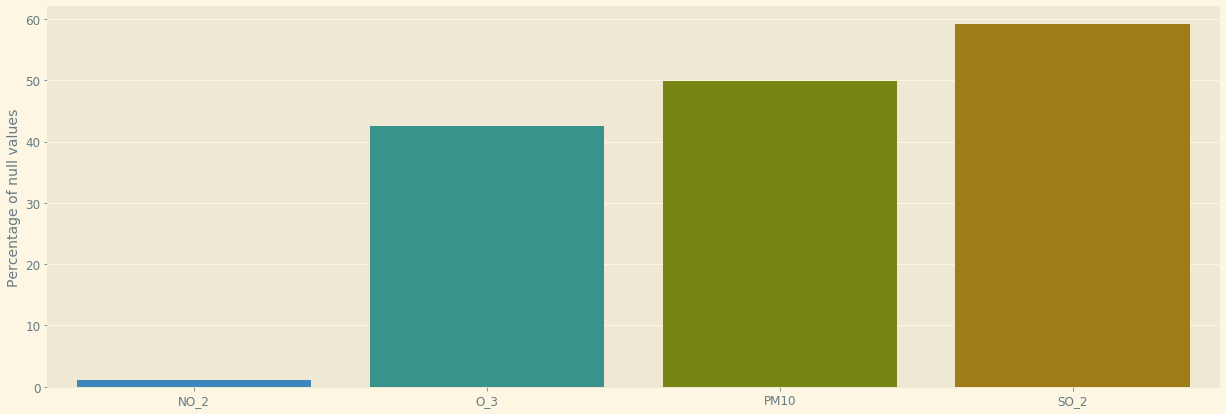

In [3]:
# Plot percentage of null values per column

fig, ax = plt.subplots(figsize=(21,7))

null_percentages = (df_full[particles_of_interest].isnull().mean()*100).to_frame()
sns.barplot(x = null_percentages.index, y = null_percentages[0], data = null_percentages)
plt.ylabel('Percentage of null values')
plt.show()

Text(0, 0.5, 'NO_2')

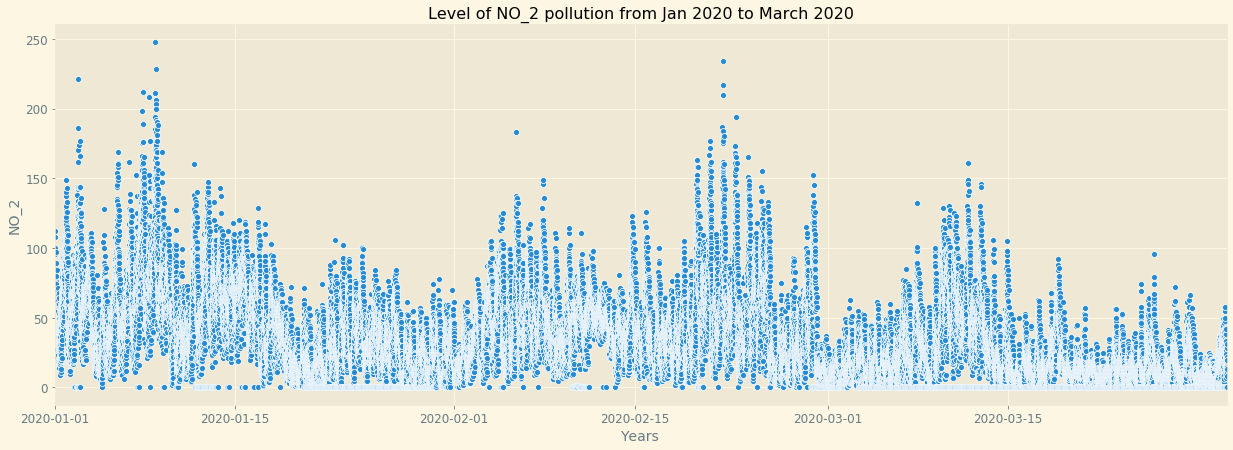

In [4]:
# Plot target variable

particle_of_interest='NO_2'

fig, ax = plt.subplots(figsize=(21,7))

sns.scatterplot(x = df_temp.index, y = df_temp[particle_of_interest])
ax.axes.set_xlim(df_temp.index.min(), df_temp.index.max())
plt.title(f'Level of {particle_of_interest} pollution from Jan 2020 to March 2020') 
plt.xlabel('Years')
plt.ylabel(particle_of_interest)

Text(0, 0.5, 'NO_2')

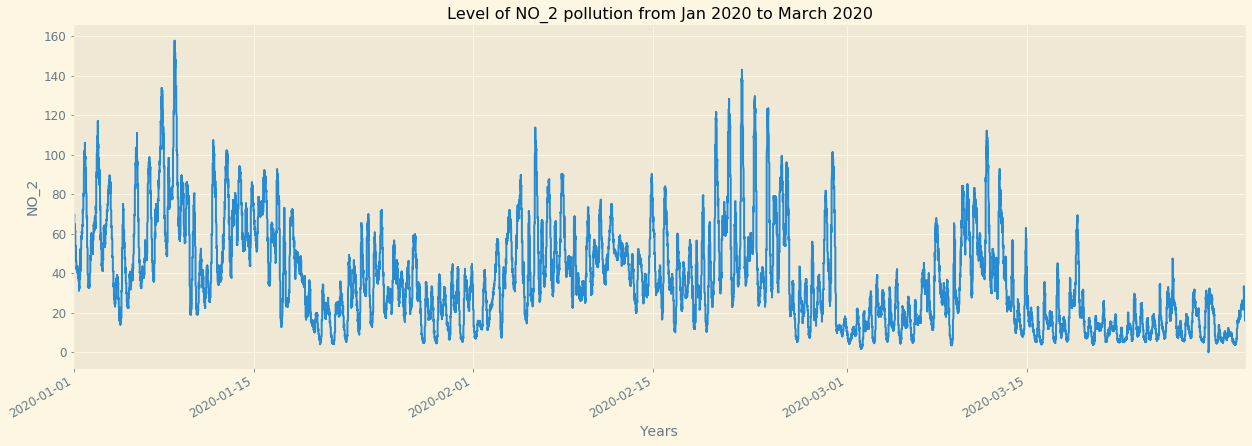

In [5]:
# Plot target variable

particle_of_interest='NO_2'

fig, ax = plt.subplots(figsize=(21,7))
df_temp[particle_of_interest].rolling(window=24).mean().plot()
ax.axes.set_xlim(df_temp.index.min(), df_temp.index.max())
plt.title(f'Level of {particle_of_interest} pollution from Jan 2020 to March 2020') 
plt.xlabel('Years')
plt.ylabel(particle_of_interest)

Text(0.5, 1.0, 'Range of NO2 contamination in the first 3 months of 2020')

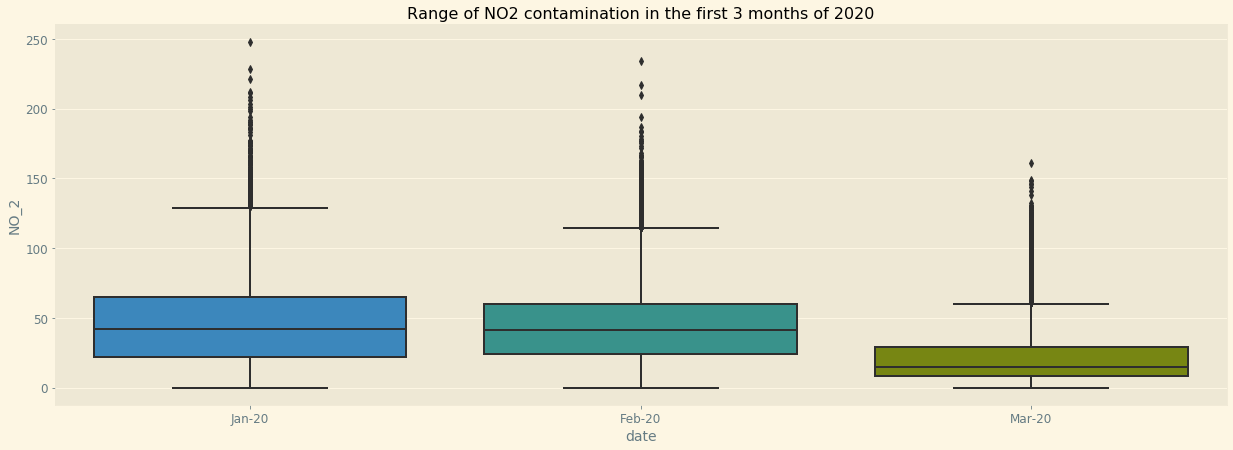

In [23]:
# Plot the range and year on year variability of the target variable 

fig, ax = plt.subplots(figsize=(21,7))

sns.boxplot(df_temp.index.month, df_temp[particle_of_interest])
ax.set_xticklabels(['Jan-20', 'Feb-20', 'Mar-20'])
plt.title('Range of NO2 contamination in the first 3 months of 2020')

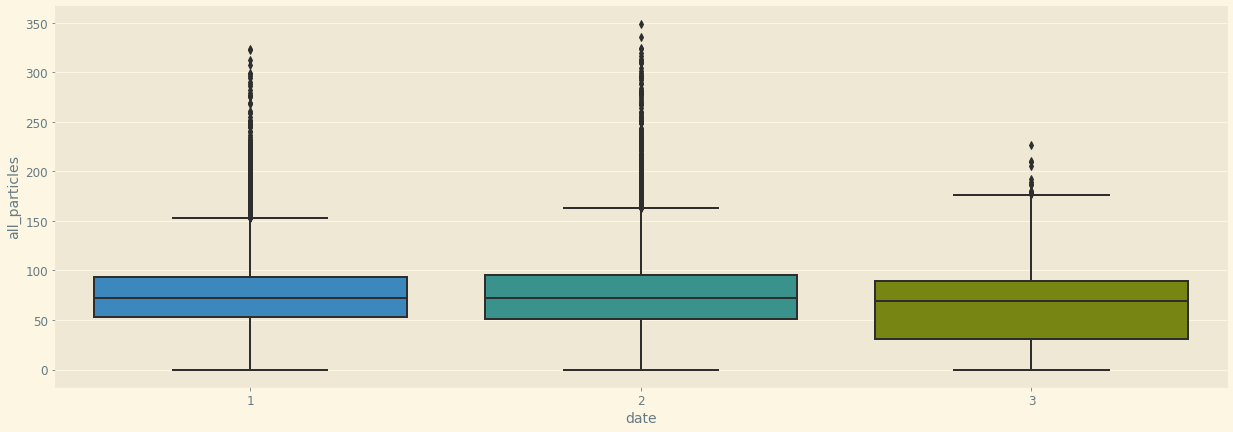

In [7]:
# Plot the range and year on year variability of the target variable 

fig, ax = plt.subplots(figsize=(21,7))

sns.boxplot(df_temp.index.month, df_temp['all_particles'])

In [8]:
# Merge geo locations from locations dataframe with main dataframe

df_stations = pd.read_hdf('madrid.h5', key='master')
df_stations['name_id'] = df_stations['name'] +' ID: ' + df_stations['id'].astype(str)

df_map = df_temp.merge(df_stations[['id', 'name', 'lat', 'lon']], left_on = ['station'], right_on = ['id'], how = 'left')
df_map.index = df_temp.index
df_map.drop(columns=['id'], inplace=True)
print(df_map.shape)
df_map.head()

(52416, 17)


,NO_2,O_3,PM10,SO_2,all_particles,station,quarter,dayofyear,dayofmonth,weekyear,weekday,hour,year,month,name,lat,lon
date,,,,,,,,,,,,,,,,,
2020-01-01,63.0,4.79,0.0,13.0,80.79,28079035,1,1,1,1,2,0,2020,1,Pza. del Carmen,40.419208,-3.703172
2020-01-01,48.0,0.00,0.0,7.0,55.00,28079004,1,1,1,1,2,0,2020,1,Pza. de España,40.423853,-3.712247
2020-01-01,112.0,0.00,0.0,24.0,136.00,28079040,1,1,1,1,2,0,2020,1,Vallecas,40.388153,-3.651522
2020-01-01,85.0,1.00,63.0,8.0,157.00,28079008,1,1,1,1,2,0,2020,1,Escuelas Aguirre,40.421564,-3.682319
2020-01-01,54.0,1.00,0.0,0.0,55.00,28079016,1,1,1,1,2,0,2020,1,Arturo Soria,40.440047,-3.639233


In [9]:
data_to_plot = df_map.loc['2017-01-01':]
heat_df = []
particle_of_interest = 'NO_2'
for i, (index, row) in enumerate(data_to_plot.iterrows()):
    if i % 1000 == 0:
        print(index)
    
    station = row['name']
    lat = row['lat']
    lon = row['lon']
    _data = [{
        'datetime': index,
        particle_of_interest: 1,
        'station': station,
        'lat': lat,
        'lon': lon,        
    } for i in range(int(row[particle_of_interest] / 10))]
    heat_df.extend(_data)

heat_df = pd.DataFrame(heat_df)
print(heat_df.shape)
heat_df.head()

2020-01-01 00:00:00
2020-01-02 17:00:00
2020-01-04 11:00:00
2020-01-06 05:00:00
2020-01-07 22:00:00
2020-01-09 16:00:00
2020-01-11 10:00:00
2020-01-13 03:00:00
2020-01-14 21:00:00
2020-01-16 15:00:00
2020-01-18 08:00:00
2020-01-20 02:00:00
2020-01-21 20:00:00
2020-01-23 13:00:00
2020-01-25 07:00:00
2020-01-27 01:00:00
2020-01-28 18:00:00
2020-01-30 12:00:00
2020-02-01 06:00:00
2020-02-02 23:00:00
2020-02-04 17:00:00
2020-02-06 11:00:00
2020-02-08 04:00:00
2020-02-09 22:00:00
2020-02-11 16:00:00
2020-02-13 09:00:00
2020-02-15 03:00:00
2020-02-16 21:00:00
2020-02-18 14:00:00
2020-02-20 08:00:00
2020-02-22 02:00:00
2020-02-23 19:00:00
2020-02-25 13:00:00
2020-02-27 07:00:00
2020-02-29 00:00:00
2020-03-01 18:00:00
2020-03-03 12:00:00
2020-03-05 05:00:00
2020-03-06 23:00:00
2020-03-08 17:00:00
2020-03-10 10:00:00
2020-03-12 04:00:00
2020-03-13 22:00:00
2020-03-15 15:00:00
2020-03-17 09:00:00
2020-03-19 03:00:00
2020-03-20 20:00:00
2020-03-22 14:00:00
2020-03-24 08:00:00
2020-03-26 01:00:00


,datetime,NO_2,station,lat,lon
0,2020-01-01,1,Pza. del Carmen,40.419208,-3.703172
1,2020-01-01,1,Pza. del Carmen,40.419208,-3.703172
2,2020-01-01,1,Pza. del Carmen,40.419208,-3.703172
3,2020-01-01,1,Pza. del Carmen,40.419208,-3.703172
4,2020-01-01,1,Pza. del Carmen,40.419208,-3.703172


In [19]:
# Visualise levels of pollution in stations of interest throughout the days of the year

locations  = df_stations[['lat', 'lon']]
locationlist = locations.values.tolist()

popup = df_stations[['name_id']]

gradient={0.2: 'blue', 0.6: 'lime', 0.8: 'orange', 1: 'red'}

basemap4 = folium.Map(location=[40.44, -3.69], zoom_start=12)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=popup.iloc[point,0]).add_to(basemap4)

df_dayofyear_list = []
for dayofyear in heat_df['datetime'].dt.dayofyear.sort_values().unique():
    df_dayofyear_list.append(heat_df.loc[heat_df['datetime'].dt.dayofyear == dayofyear, \
    ['lat', 'lon', particle_of_interest]].groupby(['lat', 'lon']).sum().reset_index().values.tolist())   

hm = HeatMapWithTime(df_dayofyear_list, radius=100, min_opacity=0.5, max_opacity=0.8, \
                             use_local_extrema=True, gradient=gradient, auto_play=True)

hm.add_to(basemap4)
basemap4.save('Jan_Mar2020map2.html')
basemap4